<a href="https://colab.research.google.com/github/Ngolobe/Forecasting-The-Stock-Market-with-Machine-Learning/blob/master/keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


#Predicting The Stock Market

Let's first import the necessary libraries!

In [2]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


#Getting The Data

In [62]:
# Define the instruments to download. We would like to see the S&P500 index.
ticker = '^GSPC'

# We would like all available data from 01/01/1971 until 12/31/2019.
start_date = '1971-01-01'
end_date = '2019-12-31'

# Use pandas_reader.data.DataReader to load the desired data. 
df = data.DataReader('^GSPC', 'yahoo', start_date, end_date)
df = df.reset_index()
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,1971-01-04,92.190002,90.639999,92.150002,91.150002,10010000,91.150002
1,1971-01-05,92.279999,90.690002,91.150002,91.800003,12600000,91.800003
2,1971-01-06,93.000000,91.500000,91.800003,92.349998,16960000,92.349998
3,1971-01-07,93.260002,91.750000,92.349998,92.379997,16460000,92.379997
4,1971-01-08,93.019997,91.599998,92.379997,92.190002,14100000,92.190002


In [63]:
#check the data types of all the other columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12359 entries, 0 to 12358
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       12359 non-null  datetime64[ns]
 1   High       12359 non-null  float64       
 2   Low        12359 non-null  float64       
 3   Open       12359 non-null  float64       
 4   Close      12359 non-null  float64       
 5   Volume     12359 non-null  int64         
 6   Adj Close  12359 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 676.0 KB


##Splitting Data into a Training set and a Test set

In [64]:
# First calculate the mid prices from the highest and lowest
high_prices = df.loc[:,'High'].values
low_prices = df.loc[:,'Low'].values
mid_prices = (high_prices+low_prices)/2.0

In [65]:
# 12359 is the length of our data frame
train_data = mid_prices[:11000]
test_data = mid_prices[11000:]

####Normalizing the Data

In [66]:
# Scale the data to be between 0 and 1
# When scaling remember! You normalize both test and train data with respect to training data
# Because you are not supposed to have access to test data
scaler = MinMaxScaler(feature_range=(0,1))
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

In [67]:
# Train the Scaler with training data and smooth data
smoothing_window_size = 2500
for di in range(0,10000,smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

# You normalize the last bit of remaining data
scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])

In [68]:
print(type(train_data))
print(len(train_data))

<class 'numpy.ndarray'>
11000


##Incorporating Timesteps Into Data

It's required that we should input our data in the form of a 3D array to the LSTM model. First, we create data in 60 timesteps before using numpy to convert it into an array. Finally, we convert the data into a 3D array with X_train samples, 60 timestamps, and one feature at each step.

In [69]:
X_train = []
y_train = []
for i in range(60, len(train_data)):
  X_train.append(train_data[i-60:i, 0])
  y_train.append(train_data[i, 0])
  
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

##Creating the LSTM Model

Before we can develop the LSTM, we have to make a few imports from **Keras**: **Sequential** for initializing the neural network, **LSTM** to add the LSTM layer, **Dropout** for preventing overfitting with dropout layers, and **Dense** to add a densely connected neural network layer.

In [11]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense

The LSTM layer is added with the following arguments: **50 units** is the dimensionality of the output space, **return_sequences=True** is necessary for stacking LSTM layers so the consequent LSTM layer has a three-dimensional sequence input, and **input_shape** is the shape of the training dataset.

Specifying 0.2 in the Dropout layer means that 20% of the layers will be dropped. Following the LSTM and Dropout layers, we add the Dense layer that specifies an output of one unit. To compile our model we shall use the **Adam** optimizer and set the loss as the **mean_squared_error**. After that, we fit the model to run for 100 epochs with a batch size of 32.

In [12]:
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam',loss='mean_squared_error')
model.fit(X_train,y_train,epochs=100,batch_size=32)

Epoch 1/100
342/342 [==============================] - 19s 55ms/step - loss: 0.0086
Epoch 2/100
342/342 [==============================] - 19s 55ms/step - loss: 0.0039
Epoch 3/100
342/342 [==============================] - 19s 55ms/step - loss: 0.0032
Epoch 4/100
342/342 [==============================] - 19s 55ms/step - loss: 0.0028
Epoch 5/100
342/342 [==============================] - 19s 55ms/step - loss: 0.0025
Epoch 6/100
342/342 [==============================] - 19s 55ms/step - loss: 0.0020
Epoch 7/100
342/342 [==============================] - 19s 56ms/step - loss: 0.0019
Epoch 8/100
342/342 [==============================] - 19s 55ms/step - loss: 0.0017
Epoch 9/100
342/342 [==============================] - 19s 55ms/step - loss: 0.0017
Epoch 10/100
342/342 [==============================] - 19s 55ms/step - loss: 0.0015
Epoch 11/100
342/342 [==============================] - 19s 55ms/step - loss: 0.0013
Epoch 12/100
342/342 [==============================] - 19s 55ms/step - lo

##Making Predictions on the Test Set

Before predicting future stock prices, we set 60 as the time step again, use **MinMaxScaler**, and reshape data. Then, **inverse_transform** puts the stock prices in a normal readable format.

In [70]:
dataset_total = mid_prices
inputs = dataset_total[len(dataset_total) - len(test_data) - 60:]
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)
X_test = []
for i in range(60, len(inputs)):
  X_test.append(inputs[i-60:i, 0])
  
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1)) 
predicted_stock_price = model.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

In [71]:
predicted_stock_price

array([[1106.6035],
       [1094.9873],
       [1047.4539],
       ...,
       [2092.5588],
       [2092.513 ],
       [2092.297 ]], dtype=float32)

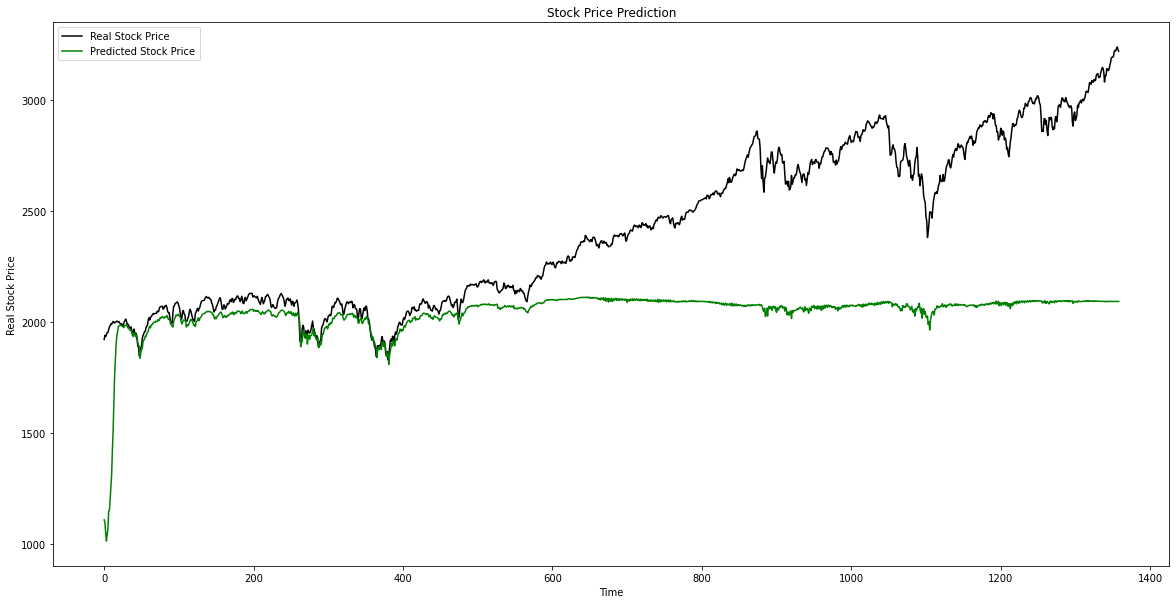

In [72]:
plt.figure(figsize=(20,10))
plt.plot(test_data, color = 'black', label = 'Real Stock Price')
plt.plot(predicted_stock_price, color = 'green', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Real Stock Price')
plt.legend()
plt.show()